# HRV and BPM

Heart Rate Variability (HRV) is the measure of how variable the distances between the r peaks is. This is very sensitive to outliers.

Beats Per Minute (BPM) is the amount of r peaks that occur, on average, in a minute. 

In [5]:
# Add the src directory to the path
import sys
sys.path.append("../src")

In [6]:
import math

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
%matplotlib notebook

import preperation
import processing
from modelling import peak_detect
from preperation import SignalHandler, DataHandler

np.set_printoptions(suppress=True)

In [7]:
dh = DataHandler()
def run_model(id, session):
    session_obj = dh.select_session(id, session)

    signal_handler = session_obj.load_signal("ECG")
    signal_handler.signal = signal_handler.signal
    print("Signal Length: ", len(signal_handler))

    peaks, y_peaks, groups, rr_interval, _ = peak_detect.process_peaks(signal_handler.signal)
    signal = signal_handler.signal
    values = preperation.display.plot_signal_peaks(signal, peaks, groups)
    return rr_interval, values

def plot_rr_interval(rr, ax=None):
    avg = processing.moving_average(rr, 40)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_ylim((0.2, 1.6))
    ax.set_ylabel("RR Interval")
    ax.set_xlabel("No. of Samples")
    ax.plot(rr, 'r', alpha=0.1)
    ax.plot(avg, 'r', linewidth=2)
    
    
def get_rmssd_hrv(rr, sections=3):
    hrv_total = []
    hrv_sections = []
    for j in range(len(rr) // sections):
        values = rr[j*sections:j*sections+sections]
        rr_delta = []
        for i in range(len(values)-1):
            d = (values[i] - values[i+1]) ** 2
            rr_delta.append(d)
        hrv = math.sqrt(1 / (len(values)-2) * sum(rr_delta))
        hrv_sections.append(hrv)
    
    for i in range(len(rr)-1):
        d = (rr[i] - rr[i+1]) ** 2
        hrv_total.append(d)
    hrv = math.sqrt(1 / (len(rr)-2) * sum(hrv_total))
    return hrv, hrv_sections

def get_bpm(rr):
    bpm_sections = []
    
    for rr_interval in rr:
        bpm = 60 / rr_interval
        bpm_sections.append(bpm)
    
    bpm_mean = sum(bpm_sections) / len(bpm_sections)
    
    return bpm_mean, bpm_sections

Signal Length:  2126880


<IPython.core.display.Javascript object>


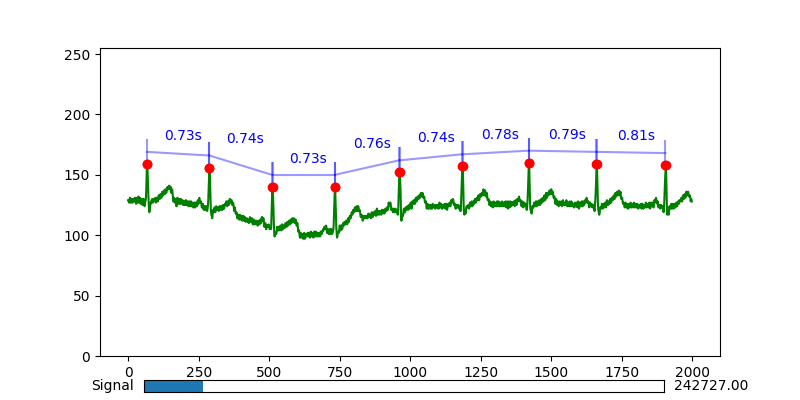

In [8]:
rr_night, v1 = run_model(id="b541610f2698f929dd0fc13461d97efb", session="1561038239.8006907")

## Outlier Detection

The peak detection is not perfect. Occasionally wrong peaks are identified that skew the results. Unlike Beats Per Minute (BPM), Heart Rate Variability (HRV) is highly influenced by outliers in the data.

![Outlier On HRV](images/hrv_outlier_effects.png)

![Example of outlier](images/outlier_example_rr.png)
Figure 1: Error in peak detection found at index 561459 of the above plot


As a result, a simple outlier detection function is defined below to remove outliers using the z-score.

Formula for Z score = (Observation — Mean)/Standard Deviation

The code was obtained from here [medium article](https://medium.com/datadriveninvestor/finding-outliers-in-dataset-using-python-efc3fce6ce32)

In [9]:
def detect_outlier(data_1): 
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    non_outliers = []
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) < threshold:
            non_outliers.append(y)
    return non_outliers

<IPython.core.display.Javascript object>


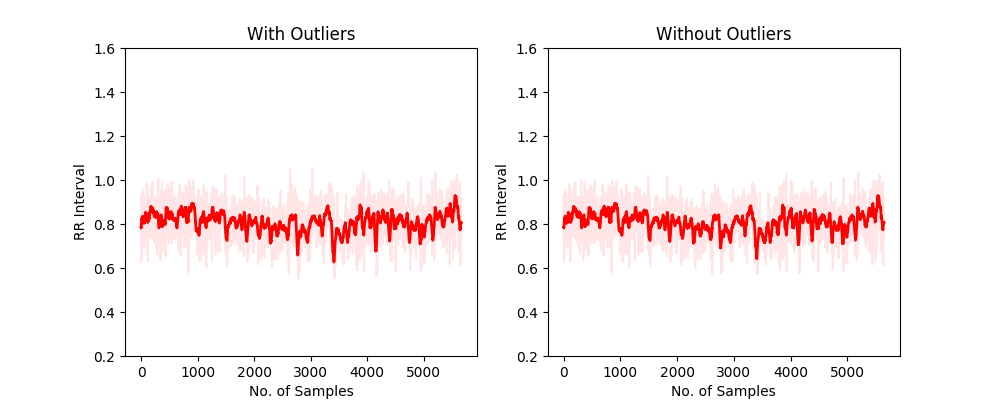

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

axes[0].set_title("With Outliers")
axes[1].set_title("Without Outliers")

plot_rr_interval(rr_night, axes[0])
plot_rr_interval(detect_outlier(rr_night), axes[1])

<IPython.core.display.Javascript object>


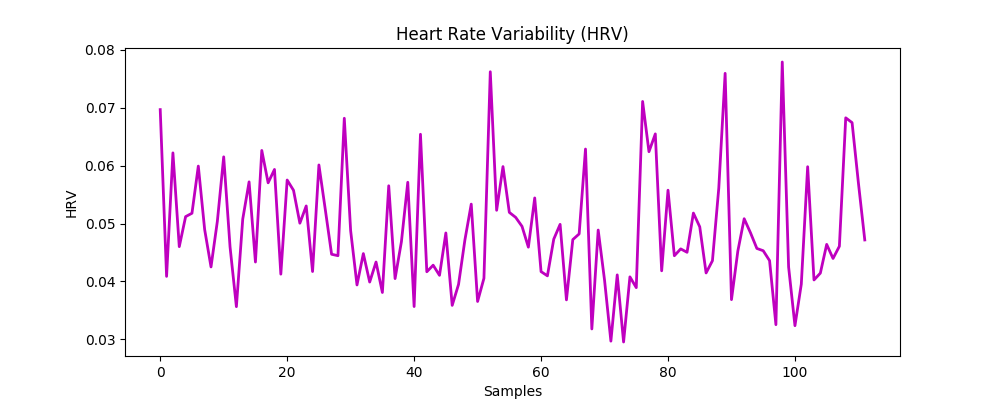

Overall HRV:  0.04979702922537873


In [14]:
import statistics
sans_outlier = detect_outlier(rr_night)

fig, ax = plt.subplots(figsize=(10, 4))

ax.set_title("Heart Rate Variability (HRV)")
ax.set_xlabel("Samples")
ax.set_ylabel("HRV")

hrv, hrv_sections = get_rmssd_hrv(sans_outlier, 50)
ax.plot(detect_outlier(hrv_sections), 'm', linewidth=2)
print("Overall HRV: ", hrv)

<IPython.core.display.Javascript object>


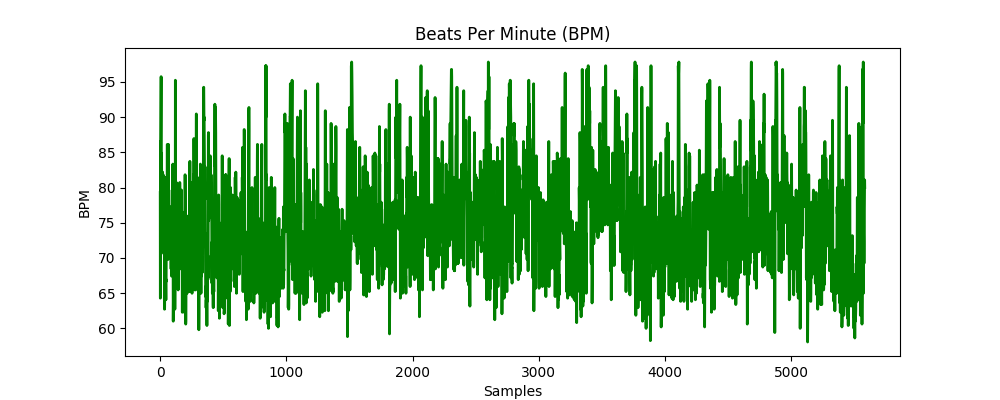

Overall BPM:  74.93088145560307


In [16]:
import statistics
sans_outlier = detect_outlier(rr_night)

fig, ax = plt.subplots(figsize=(10, 4))

ax.set_title("Beats Per Minute (BPM)")
ax.set_xlabel("Samples")
ax.set_ylabel("BPM")

bpm, bpm_sections = get_bpm(sans_outlier)
ax.plot(detect_outlier(bpm_sections), 'g', linewidth=2)
print("Overall BPM: ", bpm)